In [1]:
# for reading writing and visulaizing the image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# for creating the model
import torch
import torchvision
from time import time
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torchsummary import summary

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### *DATA IMPORTS*

In [3]:
transform = transforms.Compose([transforms.Resize(300),transforms.CenterCrop(256),transforms.ToTensor()])

In [4]:
data_dir = 'C:\\Users\\Ayush\\Desktop\\ML PROJECTS\\GAN\\data'
dataset = datasets.ImageFolder(root=data_dir,transform=transform)
train_loader = DataLoader(dataset,batch_size=16,shuffle=False)

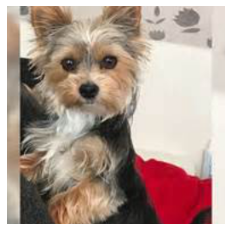

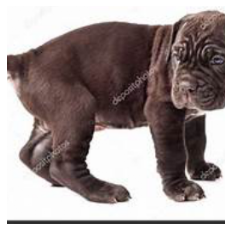

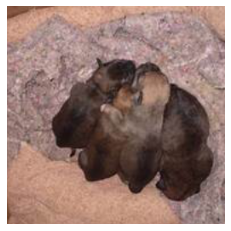

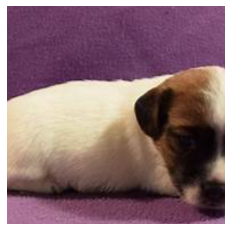

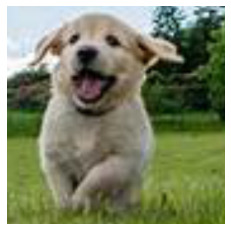

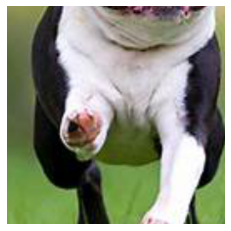

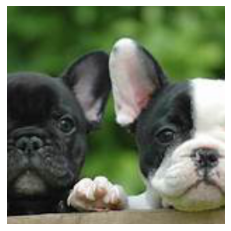

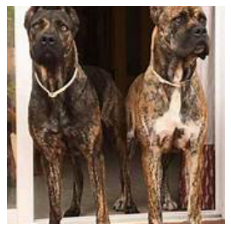

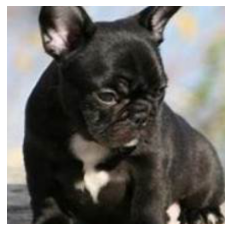

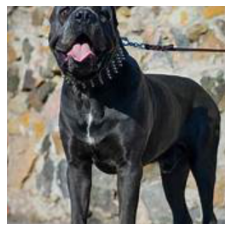

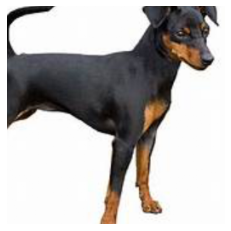

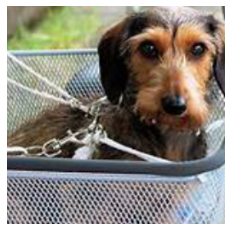

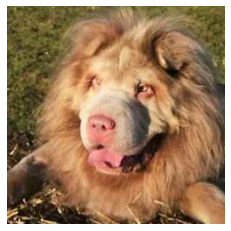

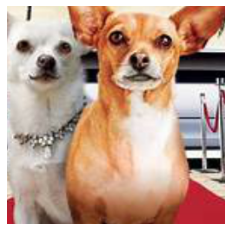

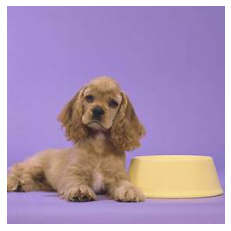

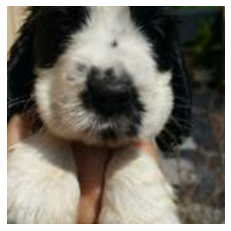

In [5]:
for i in range(16):
    a = next(iter(train_loader))[0][i]
    a = a.numpy()
    plt.imshow(np.transpose(a,(1,2,0)))
    plt.axis('off')
    plt.show()

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = nn.Sequential(
            # shape is (3,256,256)
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            # shape is (16,128,128)
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            # shape is (32,64,64)
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            # shape is (64,32,32)
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            # shape is (128,16,16)
            nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
            # shape is (128,16,16)
        ).to(device)
        self.decoder = nn.Sequential(
            # shape is (128,16,16)
            nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=2,stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # shape is (64,32,32)
            nn.ConvTranspose2d(in_channels=64,out_channels=32,kernel_size=2,stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # shape is (32,64,64)
            nn.ConvTranspose2d(in_channels=32,out_channels=16,kernel_size=2,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            # shape is (16,128,128)
            nn.ConvTranspose2d(in_channels=16,out_channels=3,kernel_size=2,stride=2),
            nn.BatchNorm2d(3),
            nn.Tanh()
            # shape is (3,256,256)
        ).to(device)

    def forward(self,x):
        # shape of x is (3,256,256)
        op = self.encoder(x)
        op = self.decoder(op)
        return op

In [7]:
model = Autoencoder().to(device)
summary(model,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             448
       BatchNorm2d-2         [-1, 16, 256, 256]              32
              ReLU-3         [-1, 16, 256, 256]               0
         MaxPool2d-4         [-1, 16, 128, 128]               0
            Conv2d-5         [-1, 32, 128, 128]           4,640
       BatchNorm2d-6         [-1, 32, 128, 128]              64
              ReLU-7         [-1, 32, 128, 128]               0
         MaxPool2d-8           [-1, 32, 64, 64]               0
            Conv2d-9           [-1, 64, 64, 64]          18,496
      BatchNorm2d-10           [-1, 64, 64, 64]             128
             ReLU-11           [-1, 64, 64, 64]               0
        MaxPool2d-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 32, 32]          73,856
      BatchNorm2d-14          [-1, 128,

In [8]:
torch.random.seed(10)
batch_size = 16
lr = 1e-3
epochs = 10
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

In [9]:
def train(epochs):
    LOSS = []
    for epoch in range(1,epochs+1):
        total_loss = 0
        for i,batch in enumerate(train_loader,1):
            model_input = (batch[0]/1.0 + torch.randn(batch[0].shape)*3e-1).to(device)
            model_output = model(model_input)
            loss = criterion(model_output,model_input)
            total_loss+= loss.item()
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if i%100==0:
                print('Epoch [{}] ({}/{}), train_loss = {:.4f}'.format(epoch, i, len(train_loader), loss.item()))    
        print("\n")
        LOSS.append(total_loss)
    return LOSS

In [10]:
from time import time
tic = time()
losses = train(epochs)
print("\nTime Elapsed:",time()-tic,"sec")

Epoch [1] (100/304), train_loss = 0.2553
Epoch [1] (200/304), train_loss = 0.1999
Epoch [1] (300/304), train_loss = 0.1529


Epoch [2] (100/304), train_loss = 0.1340
Epoch [2] (200/304), train_loss = 0.1317
Epoch [2] (300/304), train_loss = 0.1157


Epoch [3] (100/304), train_loss = 0.1109
Epoch [3] (200/304), train_loss = 0.1117
Epoch [3] (300/304), train_loss = 0.1047


Epoch [4] (100/304), train_loss = 0.1012
Epoch [4] (200/304), train_loss = 0.1044
Epoch [4] (300/304), train_loss = 0.1043


Epoch [5] (100/304), train_loss = 0.1001
Epoch [5] (200/304), train_loss = 0.1023
Epoch [5] (300/304), train_loss = 0.1022


Epoch [6] (100/304), train_loss = 0.0978
Epoch [6] (200/304), train_loss = 0.1045
Epoch [6] (300/304), train_loss = 0.1006


Epoch [7] (100/304), train_loss = 0.0974
Epoch [7] (200/304), train_loss = 0.0993
Epoch [7] (300/304), train_loss = 0.1009


Epoch [8] (100/304), train_loss = 0.0969
Epoch [8] (200/304), train_loss = 0.0980
Epoch [8] (300/304), train_loss = 0.0998




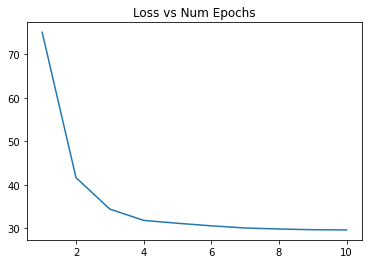

In [11]:
plt.plot(range(1,epochs+1),losses)
plt.title("Loss vs Num Epochs")
plt.show()

In [12]:
b = next(iter(train_loader))[0][11]
b = b.numpy()
b = b/1.0
#b = b/255.0

### ACTUAL IMAGE

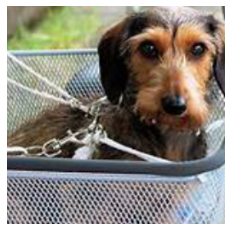

In [13]:
plt.imshow(np.transpose(b,(1,2,0)))
plt.axis('off')
plt.show()

### NOISED IMAGE

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


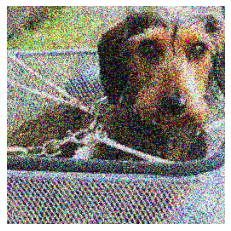

In [17]:
noise = np.random.randn(3,256,256)*3e-1
temp = b+noise
plt.imshow(np.transpose(temp,(1,2,0)))
plt.axis('off')
plt.show()

### DENOISED IMAGE

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


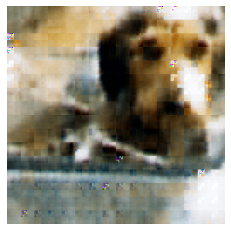

In [18]:
# showing denoised image
temp = b.reshape(1,3,256,256)
noise = np.random.randn(1,3,256,256)*3e-1
temp = temp+noise
temp = temp.astype(np.float32)
temp = torch.tensor(temp)
temp = temp.to(device)
temp = model(temp)
temp = temp.cpu().detach().numpy()
temp = temp.reshape(3,256,256)
plt.imshow(np.transpose(temp,(1,2,0)))
plt.axis('off')
plt.show()